In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as  plt
import random

#!pip install segmentation-models-pytorch==0.1.0
#!pip install -U segmentation-models-pytorch
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-i4sxqde5
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-i4sxqde5
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 653.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106723 sha256=f1acd330408f9945fe68f9ea3ca531280bda2f6ec2adc99b6512ba38e7870c93
  Stored in directory: /tmp/pip-ephem-wheel-cache-tpoxk0ls/wheels/1a/49/5f/858bc2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


In [4]:
print(torch.__version__)

2.1.0+cu118


In [5]:
##### BE AWARE TEST-TRAIN CHANGED FOR STUDY
x_train_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/train")
y_train_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/train")

x_valid_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/val")
y_valid_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/val")

x_test_dir = os.path.join( "/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/image/test")
y_test_dir = os.path.join("/content/drive/MyDrive/Deep Learning Project/F_segment/mysegment/data/lables/test")

In [6]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  300
the number of image/label in the validation:  100
the number of image/label in the test:  100


In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
CLASSES = ['1', '2', '3','4'] # There is 3 labels of input, 4th class is for background. When we implement augmentations to empty backgrounds assigned as background.

In [11]:
class Dataset(BaseDataset):
    """ Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['1','2', '3' ,'4']
    randomizeLocation = None

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
            randomizeLocation=True,
    ):
        self.randomizeLocation = randomizeLocation
        self.ids = os.listdir(images_dir)
        self.mids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.images_fps.sort()


        #self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mids]
        self.masks_fps.sort()



        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower())+1 for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        randomIndex = 0
        #if self.randomizeLocation:
        #  randomIndex = random.randint(0, len(image1) - 256)
        #image=image1[randomIndex:randomIndex+256, randomIndex:randomIndex+256,:]
        #image.shape

        #image = cv2.resize(image, (512, 512))
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[mask == 255] = 3
        mask[mask == 128] = 2
        mask[mask == 0] = 1
        #mask = cv2.resize(mask1, (512, 512))
        #mask=mask1[randomIndex:randomIndex+256, randomIndex:randomIndex+256]

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        #print(mask)

        # add background if mask is not binary
        #if mask.shape[-1] != 1:
        #    background = 1 - mask.sum(axis=-1, keepdims=True)
        #    mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

[1, 2, 3, 4]
(501, 501, 4)


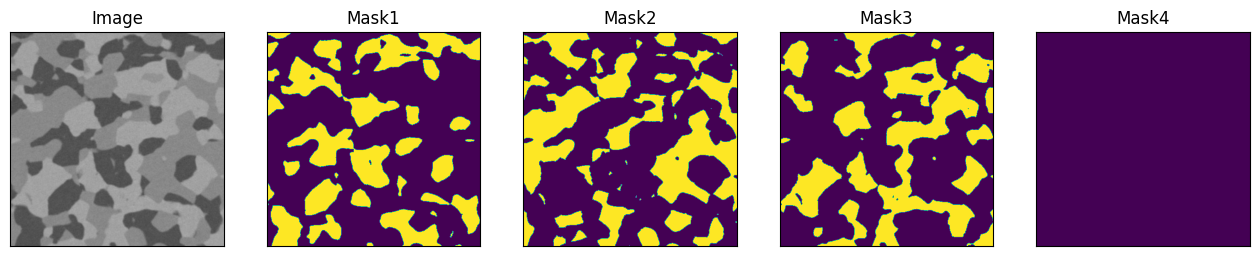

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[1] # get some sample
#print(mask)
print(mask.shape)
visualize(
    image=image,
    mask1=mask[..., 0].squeeze(),
    mask2=mask[..., 1].squeeze(),
    mask3=mask[..., 2].squeeze(),
    mask4=mask[..., 3].squeeze(),
)
print(mask[..., 0].squeeze())

In [13]:
image, mask = dataset[1]
print(image.shape, mask.shape)

(501, 501, 3) (501, 501, 4)


In [14]:
import albumentations as albu

newsize=256
def get_training_augmentation(newsize=newsize):
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=1, border_mode=0),
        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=False, border_mode=0),
        # albu.RandomCrop(height=256, width=256, always_apply=True),
        albu.Resize(newsize,newsize),

        albu.GaussNoise(p=1,var_limit=(50.0,100.0)), # adding noise
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(newsize=newsize):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.Resize(newsize,newsize),
        albu.PadIfNeeded(newsize, newsize)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

[1, 2, 3, 4]
(256, 256, 3)


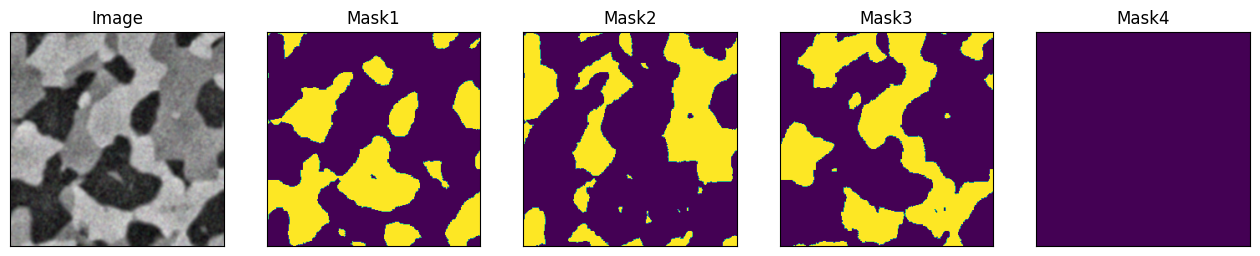

In [15]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES, augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
print(image.shape)
visualize(
    image=image,
    mask1=mask[..., 0].squeeze(),
    mask2=mask[..., 1].squeeze(),
    mask3=mask[..., 2].squeeze(),
    mask4=mask[..., 3].squeeze(),
)

Create model and train

In [16]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [17]:
#ENCODER = 'resnext50_32x4d'
ENCODER = 'vgg19'
ENCODER_WEIGHTS = 'imagenet'
#ENCODER_WEIGHTS = 'ssl'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

saveModelLocation = '/content/drive/MyDrive/Deep Learning Project/savedModels/'+ENCODER + '_' + ENCODER_WEIGHTS+'_resize_fixed.pth'

print(smp.__version__)

#n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
n_classes = len(CLASSES)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=n_classes,
    activation= 'softmax2d',
)

if torch.cuda.is_available():
    print('Cuda available')
    model.cuda()

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER,ENCODER_WEIGHTS)

0.3.3


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.7MB/s]


Cuda available


In [18]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=2)

[1, 2, 3, 4]
[1, 2, 3, 4]


In [19]:
import segmentation_models_pytorch.utils.metrics
loss = smp.utils.losses.DiceLoss()
#loss = smp.utils.losses.CrossEntropyLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [20]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)


valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [21]:
# train model

max_score = 0
num_epochs = 50
#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_acc_score = []
valid_dice_loss = []
valid_acc_score = []
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

for i in range(0, num_epochs):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_acc_score.append(train_logs['accuracy'])
    #train_acc_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_acc_score.append(valid_logs['accuracy'])
    #valid_acc_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        #max_score = valid_logs['iou_score']
        torch.save(model, saveModelLocation)

        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 50:
        optimizer.param_groups[0]['lr'] = 5e-6
        print('Decrease decoder learning rate to 5e-6!')

    if i == 75:
        optimizer.param_groups[0]['lr'] = 1e-6
        print('Decrease decoder learning rate to 1e-6!')

end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

time = start.elapsed_time(end)
print("Time elapsed: " + str(start.elapsed_time(end) / 60000) + " minutes")  # milliseconds


Epoch: 0
valid: 100%|██████████| 25/25 [00:23<00:00,  1.09it/s, dice_loss - 0.6213, iou_score - 0.285, accuracy - 0.8283, fscore - 0.442]
Model saved!

Epoch: 1
valid: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s, dice_loss - 0.5293, iou_score - 0.4641, accuracy - 0.8798, fscore - 0.633]
Model saved!

Epoch: 2
valid: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s, dice_loss - 0.3606, iou_score - 0.6839, accuracy - 0.9257, fscore - 0.812]
Model saved!

Epoch: 3
valid: 100%|██████████| 25/25 [00:03<00:00,  6.30it/s, dice_loss - 0.3373, iou_score - 0.7551, accuracy - 0.9471, fscore - 0.8596]
Model saved!

Epoch: 4
valid: 100%|██████████| 25/25 [00:06<00:00,  4.13it/s, dice_loss - 0.3043, iou_score - 0.7912, accuracy - 0.9556, fscore - 0.883]
Model saved!

Epoch: 5
valid: 100%|██████████| 25/25 [00:03<00:00,  7.01it/s, dice_loss - 0.2694, iou_score - 0.8299, accuracy - 0.9645, fscore - 0.9065]
Model saved!

Epoch: 6
valid: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s, dice_loss - 0.26

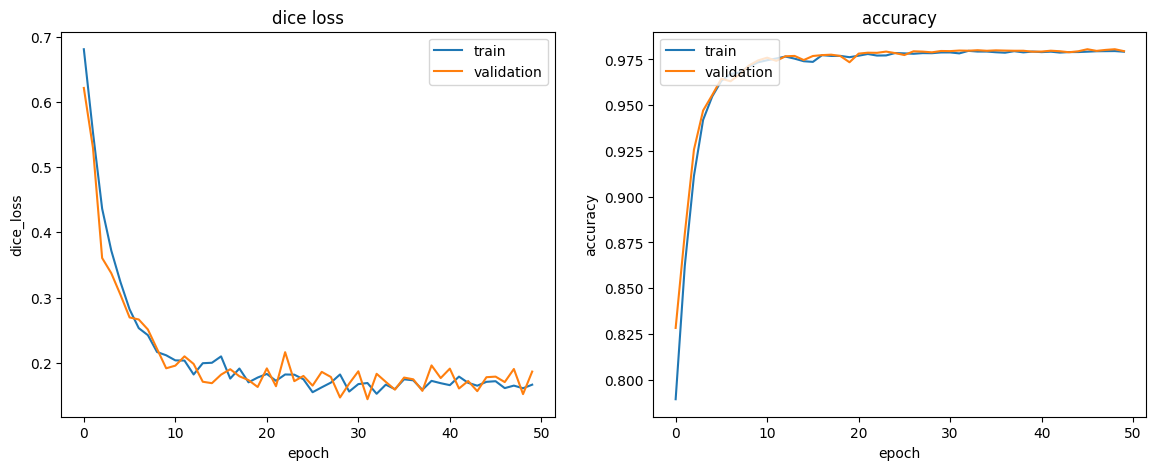

In [22]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train')
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,train_acc_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_acc_score,label='validation')
ax2.set_title("accuracy")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(loc='upper left')

saveResultLocation = '/content/drive/MyDrive/Deep Learning Project/savedResults/'+ENCODER + '_' + ENCODER_WEIGHTS+'_resize'+str(newsize)+'_epoch16_NEW-1.png'
plt.savefig(saveResultLocation)

plt.show()

Test best saved model

In [23]:
# load best saved checkpoint
best_model = torch.load(saveModelLocation)

In [24]:
# create test dataset for same sized of images - study 1
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(), # do not add augmentation
    #augmentation=get_training_augmentation(), # to add augmentation like training
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    randomizeLocation=False,
)

test_dataloader = DataLoader(test_dataset)

[1, 2, 3, 4]


In [ ]:
# create test dataset  512*512 images - study 2,3,5
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(newsize=512), # do not add augmentation
    #augmentation=get_training_augmentation(newsize=512), # to add augmentation like training
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    randomizeLocation=False,
)

test_dataloader = DataLoader(test_dataset)

[1, 2, 3, 4]


[1, 2, 3, 4]
(512, 512, 3)


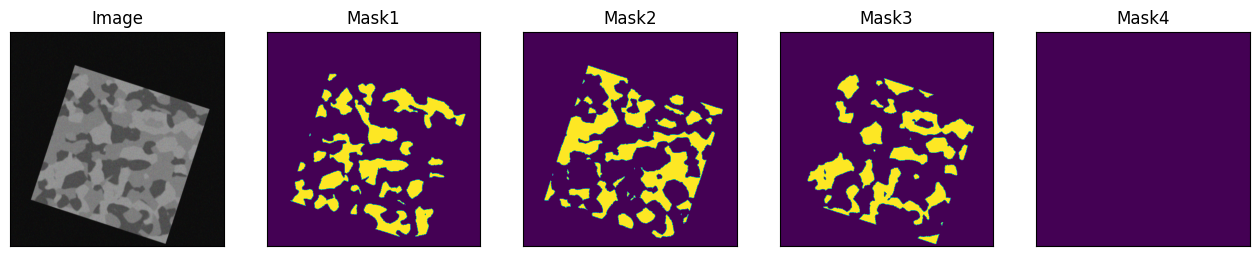

In [25]:
# Lets look at data we have to test
dataset = Dataset(x_test_dir,y_test_dir, classes=CLASSES, augmentation=get_training_augmentation(newsize=512))

image, mask = dataset[1] # get some sample
print(image.shape)
visualize(
    image=image,
    mask1=mask[..., 0].squeeze(),
    mask2=mask[..., 1].squeeze(),
    mask3=mask[..., 2].squeeze(),
    mask4=mask[..., 3].squeeze(),
)

In [26]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s, dice_loss - 0.04107, iou_score - 0.9494, accuracy - 0.987, fscore - 0.974]


Visualize predictions

In [27]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir,
    classes=CLASSES,
    randomizeLocation=False,
)

[1, 2, 3, 4]


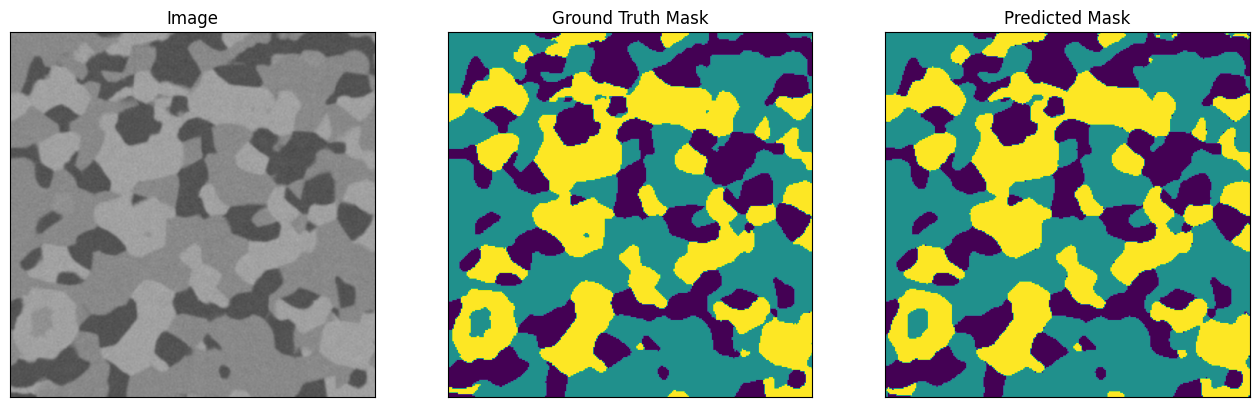

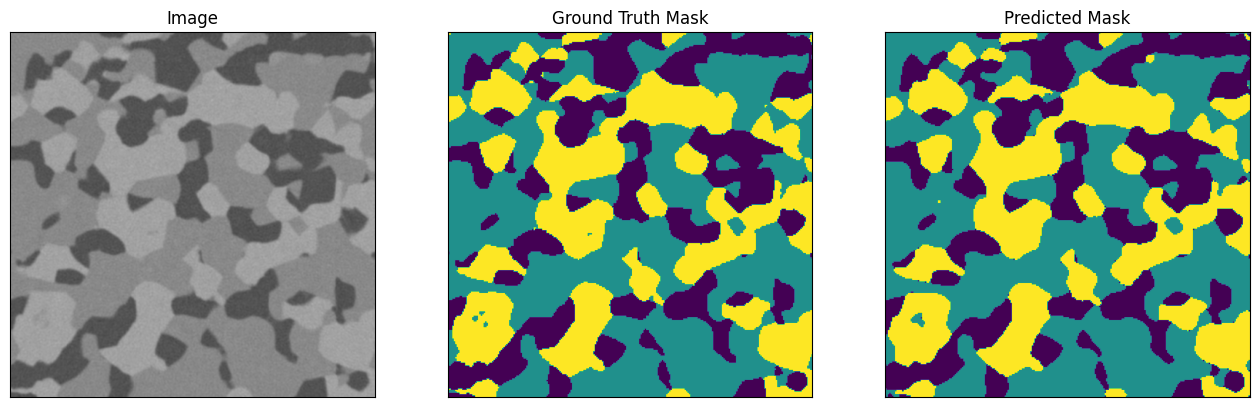

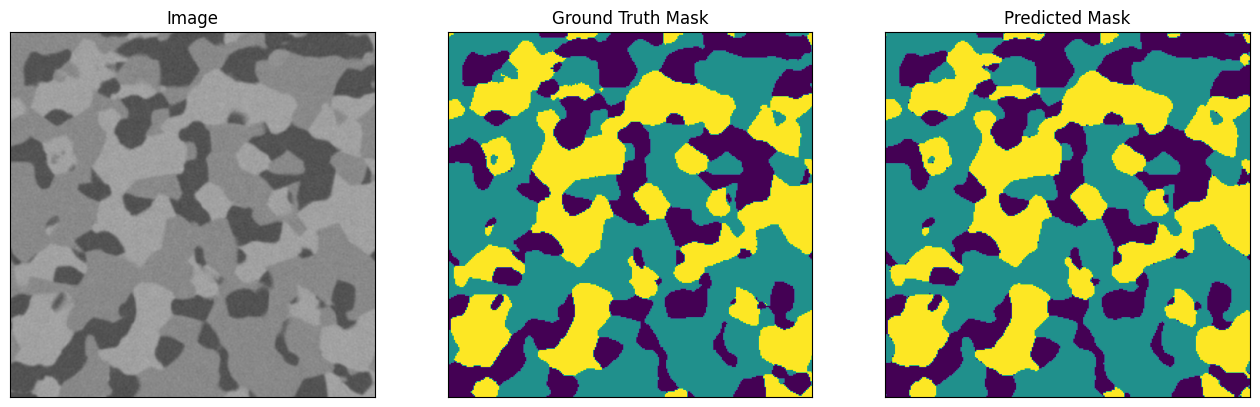

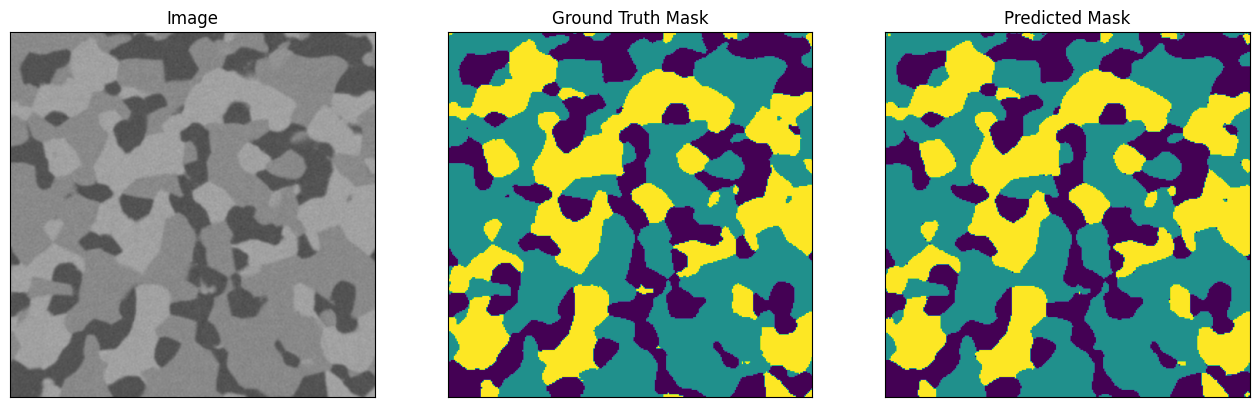

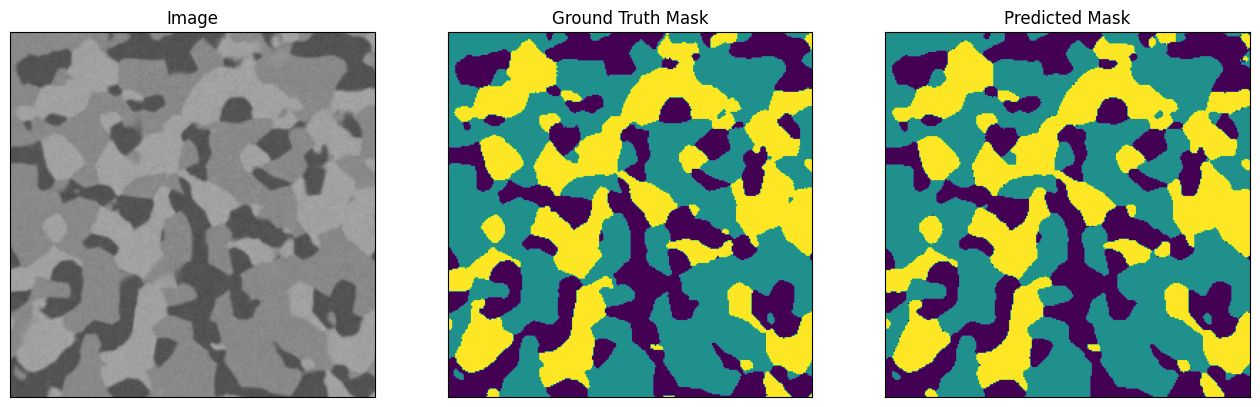

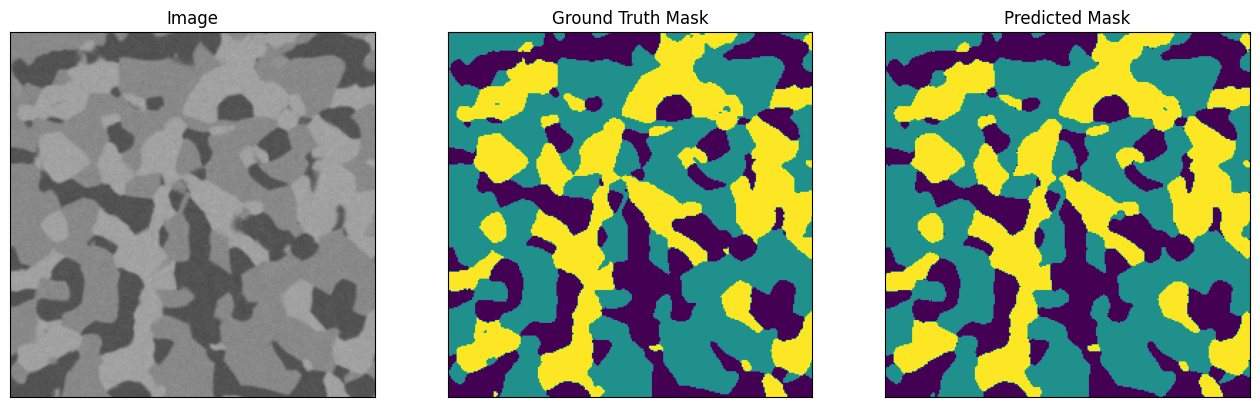

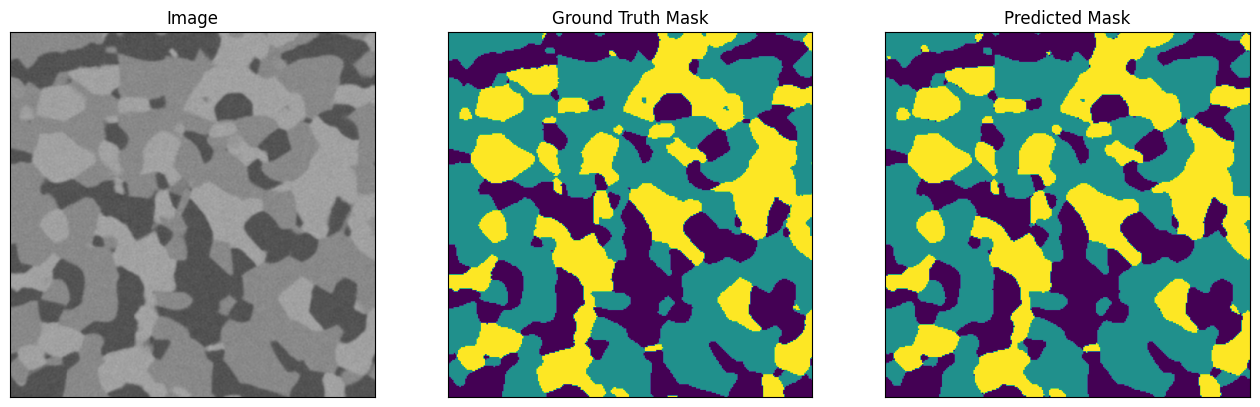

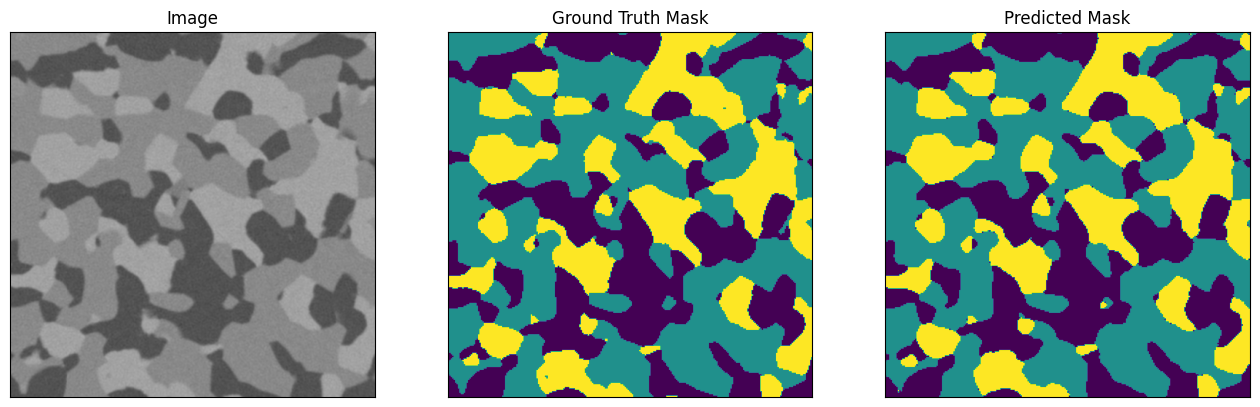

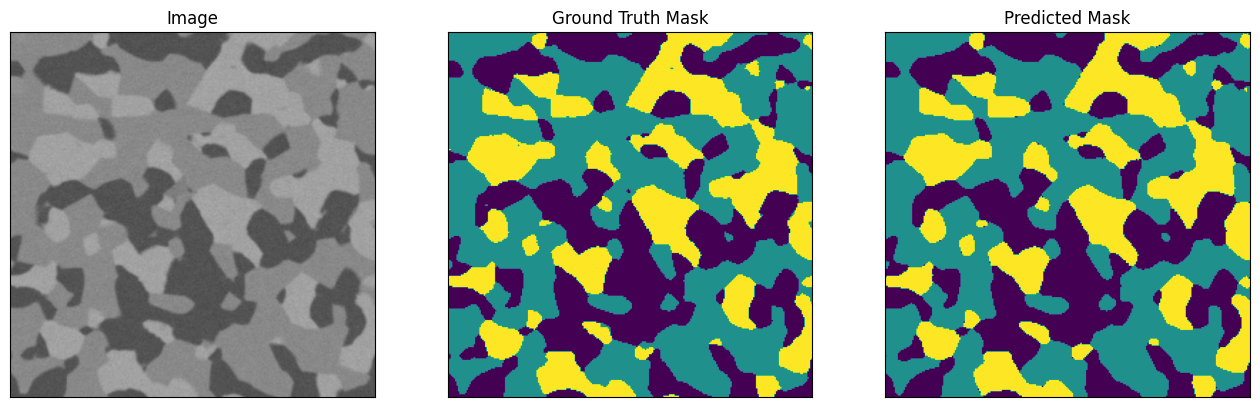

In [28]:
for i in range(10,19):

    #n = np.random.choice(len(test_dataset))
    n = i

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    pr_mask = np.transpose(pr_mask, (1, 2, 0))



    gt_mask_gray = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

    for ii in range(gt_mask.shape[2]):
        gt_mask_gray = gt_mask_gray + 1/gt_mask.shape[2]*ii*gt_mask[:,:,ii]

    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]

    visualize(
        image=image_vis,
        ground_truth_mask=gt_mask_gray,
        predicted_mask=pr_mask_gray
        #predicted_mask=pr_mask[1].squeeze()
    )

    #CLASSES = ['1', '2', '3', '4']
